Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [525]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'backward'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "potential_center_back"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
RUN_NAME = None
TARGET_OVERALL = 80

PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle','shooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']


PLAYER_ATTRIBUTES = [ 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'FKAccuracy', 'LongPassing', 'BallControl',
                       'SprintSpeed', 'Agility','Composure', 'Defense',  
                      'ShotPower',  'Strength',  'Aggression', 'Interceptions',  
                      'StandingTackle', 'SlidingTackle']



In [526]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw
from src.sport_analytics.model.eval import plot_feature_importance,plot_shap_summary,plot_auc_curves
import config as CONFIG

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [527]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [528]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw(df_raw)
df_raw = df_raw.reset_index(['ID'])
df_raw.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,,ID,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense
Name,FIFA,,,,,,,,,,,,,,,,,,,,,
G. Restes,2024,265526,18.0,18.0,https://cdn.sofifa.net/players/265/526/24_60.png,France,https://cdn.sofifa.net/flags/fr.png,70.0,871.0,Toulouse,https://cdn.sofifa.net/meta/team/289/30.png,...,23.0,7.0,871.0,18.0,70.0,GK,1,0,-2.0,7.0
A. Patterson,2024,246417,23.0,23.0,https://cdn.sofifa.net/players/246/417/24_60.png,England,https://cdn.sofifa.net/flags/gb-eng.png,72.0,822.0,Sunderland,https://cdn.sofifa.net/meta/team/3/30.png,...,36.0,5.0,822.0,23.0,72.0,GK,1,0,-2.0,5.0
Diego Callai,2024,270865,18.0,18.0,https://cdn.sofifa.net/players/270/865/24_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,65.0,812.0,Sporting CP,https://cdn.sofifa.net/meta/team/58/30.png,...,38.0,9.0,812.0,18.0,65.0,GK,1,0,-2.0,9.0
F. Jörgensen,2024,258485,21.0,21.0,https://cdn.sofifa.net/players/258/485/24_60.png,Denmark,https://cdn.sofifa.net/flags/dk.png,72.0,791.0,Villarreal,https://cdn.sofifa.net/meta/team/3477/30.png,...,27.0,7.0,791.0,21.0,72.0,GK,1,0,-2.0,7.0
P. Köhn,2024,239364,25.0,25.0,https://cdn.sofifa.net/players/239/364/24_60.png,Switzerland,https://cdn.sofifa.net/flags/ch.png,75.0,791.0,Monaco,https://cdn.sofifa.net/meta/team/6789/30.png,...,32.0,12.0,791.0,25.0,75.0,GK,1,0,-2.0,12.0


# 

In [529]:
df_raw

,,ID,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense
Name,FIFA,,,,,,,,,,,,,,,,,,,,,
G. Restes,2024,265526,18.0,18.0,https://cdn.sofifa.net/players/265/526/24_60.png,France,https://cdn.sofifa.net/flags/fr.png,70.0,871.0,Toulouse,https://cdn.sofifa.net/meta/team/289/30.png,...,23.0,7.0,871.0,18.0,70.0,GK,1,0,-2.0,7.0
A. Patterson,2024,246417,23.0,23.0,https://cdn.sofifa.net/players/246/417/24_60.png,England,https://cdn.sofifa.net/flags/gb-eng.png,72.0,822.0,Sunderland,https://cdn.sofifa.net/meta/team/3/30.png,...,36.0,5.0,822.0,23.0,72.0,GK,1,0,-2.0,5.0
Diego Callai,2024,270865,18.0,18.0,https://cdn.sofifa.net/players/270/865/24_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,65.0,812.0,Sporting CP,https://cdn.sofifa.net/meta/team/58/30.png,...,38.0,9.0,812.0,18.0,65.0,GK,1,0,-2.0,9.0
F. Jörgensen,2024,258485,21.0,21.0,https://cdn.sofifa.net/players/258/485/24_60.png,Denmark,https://cdn.sofifa.net/flags/dk.png,72.0,791.0,Villarreal,https://cdn.sofifa.net/meta/team/3477/30.png,...,27.0,7.0,791.0,21.0,72.0,GK,1,0,-2.0,7.0
P. Köhn,2024,239364,25.0,25.0,https://cdn.sofifa.net/players/239/364/24_60.png,Switzerland,https://cdn.sofifa.net/flags/ch.png,75.0,791.0,Monaco,https://cdn.sofifa.net/meta/team/6789/30.png,...,32.0,12.0,791.0,25.0,75.0,GK,1,0,-2.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Carlinhos Bala,2011,20486,30.0,30.0,https://cdn.sofifa.net/players/020/486/11_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,69.0,81.0,Atlético GO,https://cdn.sofifa.net/meta/team/8331/30.png,...,NaN,NaN,81.0,30.0,69.0,RF,0,1,1.0,44.0
A. Gerbo,2011,193268,20.0,20.0,https://cdn.sofifa.net/players/193/268/11_60.png,Italy,https://cdn.sofifa.net/flags/it.png,60.0,80.0,Triestina,https://cdn.sofifa.net/meta/team/3890/30.png,...,NaN,NaN,80.0,29.0,65.0,RF,0,1,1.0,22.0
C. Pasquato,2011,189437,20.0,20.0,https://cdn.sofifa.net/players/189/437/11_60.png,Italy,https://cdn.sofifa.net/flags/it.png,67.0,80.0,Modena,https://cdn.sofifa.net/meta/team/1000/30.png,...,NaN,NaN,80.0,21.0,74.0,RF,0,1,1.0,22.0


In [530]:
# df_raw["Potential"] = df_raw.Potential.astype('float')
# df_raw["max_potential"] = df_raw.max_potential.astype('float')

In [531]:
df_raw

,,ID,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense
Name,FIFA,,,,,,,,,,,,,,,,,,,,,
G. Restes,2024,265526,18.0,18.0,https://cdn.sofifa.net/players/265/526/24_60.png,France,https://cdn.sofifa.net/flags/fr.png,70.0,871.0,Toulouse,https://cdn.sofifa.net/meta/team/289/30.png,...,23.0,7.0,871.0,18.0,70.0,GK,1,0,-2.0,7.0
A. Patterson,2024,246417,23.0,23.0,https://cdn.sofifa.net/players/246/417/24_60.png,England,https://cdn.sofifa.net/flags/gb-eng.png,72.0,822.0,Sunderland,https://cdn.sofifa.net/meta/team/3/30.png,...,36.0,5.0,822.0,23.0,72.0,GK,1,0,-2.0,5.0
Diego Callai,2024,270865,18.0,18.0,https://cdn.sofifa.net/players/270/865/24_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,65.0,812.0,Sporting CP,https://cdn.sofifa.net/meta/team/58/30.png,...,38.0,9.0,812.0,18.0,65.0,GK,1,0,-2.0,9.0
F. Jörgensen,2024,258485,21.0,21.0,https://cdn.sofifa.net/players/258/485/24_60.png,Denmark,https://cdn.sofifa.net/flags/dk.png,72.0,791.0,Villarreal,https://cdn.sofifa.net/meta/team/3477/30.png,...,27.0,7.0,791.0,21.0,72.0,GK,1,0,-2.0,7.0
P. Köhn,2024,239364,25.0,25.0,https://cdn.sofifa.net/players/239/364/24_60.png,Switzerland,https://cdn.sofifa.net/flags/ch.png,75.0,791.0,Monaco,https://cdn.sofifa.net/meta/team/6789/30.png,...,32.0,12.0,791.0,25.0,75.0,GK,1,0,-2.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Carlinhos Bala,2011,20486,30.0,30.0,https://cdn.sofifa.net/players/020/486/11_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,69.0,81.0,Atlético GO,https://cdn.sofifa.net/meta/team/8331/30.png,...,NaN,NaN,81.0,30.0,69.0,RF,0,1,1.0,44.0
A. Gerbo,2011,193268,20.0,20.0,https://cdn.sofifa.net/players/193/268/11_60.png,Italy,https://cdn.sofifa.net/flags/it.png,60.0,80.0,Triestina,https://cdn.sofifa.net/meta/team/3890/30.png,...,NaN,NaN,80.0,29.0,65.0,RF,0,1,1.0,22.0
C. Pasquato,2011,189437,20.0,20.0,https://cdn.sofifa.net/players/189/437/11_60.png,Italy,https://cdn.sofifa.net/flags/it.png,67.0,80.0,Modena,https://cdn.sofifa.net/meta/team/1000/30.png,...,NaN,NaN,80.0,21.0,74.0,RF,0,1,1.0,22.0


In [532]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'train', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [533]:
df = df[(df.central == 1)&(df.offense == -1)]

# Training nur auf High Potentials
df = df[df.max_potential>TARGET_OVERALL]

# nur Entwicklugnsfähige Spieler
df = df[df.prime_age>df.potential_age]
df = df[df.PrimeOverall>df.Overall]
df['target'] = df.PrimeOverall
df = df[df.potential_age<23]

print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
76.0    27
79.0    27
77.0    20
75.0    19
72.0    19
74.0    18
84.0    17
78.0    16
73.0    16
70.0    16
80.0    13
71.0    13
81.0    11
83.0     9
82.0     9
68.0     8
67.0     6
86.0     4
62.0     4
65.0     4
87.0     4
85.0     3
63.0     2
89.0     2
60.0     2
69.0     2
64.0     1
61.0     1
66.0     1
90.0     1
88.0     1
Name: count, dtype: int64


In [534]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
Name,FIFA,,,,,,,,,,
Marquinhos,2014,19.0,19.0,28.0,89.0,89.0,78.0,88.0,88.0,train,CB
E. Tapsoba,2021,21.0,21.0,22.0,88.0,88.0,78.0,81.0,81.0,test,CB
W. Saliba,2020,18.0,18.0,22.0,88.0,88.0,71.0,84.0,84.0,test,CB
F. Sørensen,2012,19.0,19.0,24.0,88.0,88.0,74.0,75.0,75.0,train,CB
M. Sakho,2011,20.0,20.0,26.0,88.0,88.0,76.0,82.0,82.0,drop,CB


In [535]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [536]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Composure', 'Defensive awareness'], dtype='object')

#### Transform Value

In [537]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

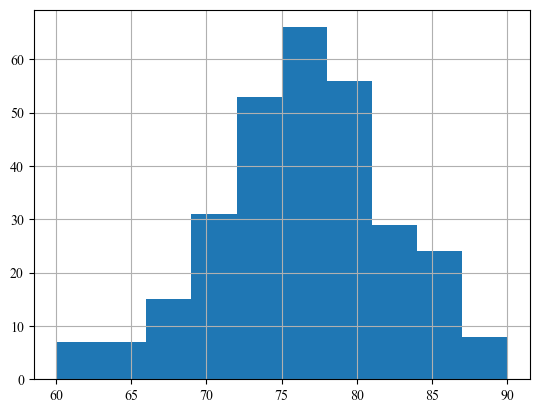

In [538]:
df['target'].hist()

In [539]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [540]:
df_processed.columns

Index(['ID', 'potential_age', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Position', 'Unnamed: 0', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Composure',
       'Defensive awareness', 'max_potential', 'prime_age', 'PrimeOverall',
       'best_position', 'central', 'winger', 'offense', 'Defense', 'set',
       'target'],
      dtype='object')

In [541]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [542]:
y_train.describe()

count    151.000000
mean      77.225166
std        5.104471
min       60.000000
25%       74.000000
50%       77.000000
75%       80.000000
max       90.000000
Name: target, dtype: float64

In [543]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [544]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [545]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [546]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


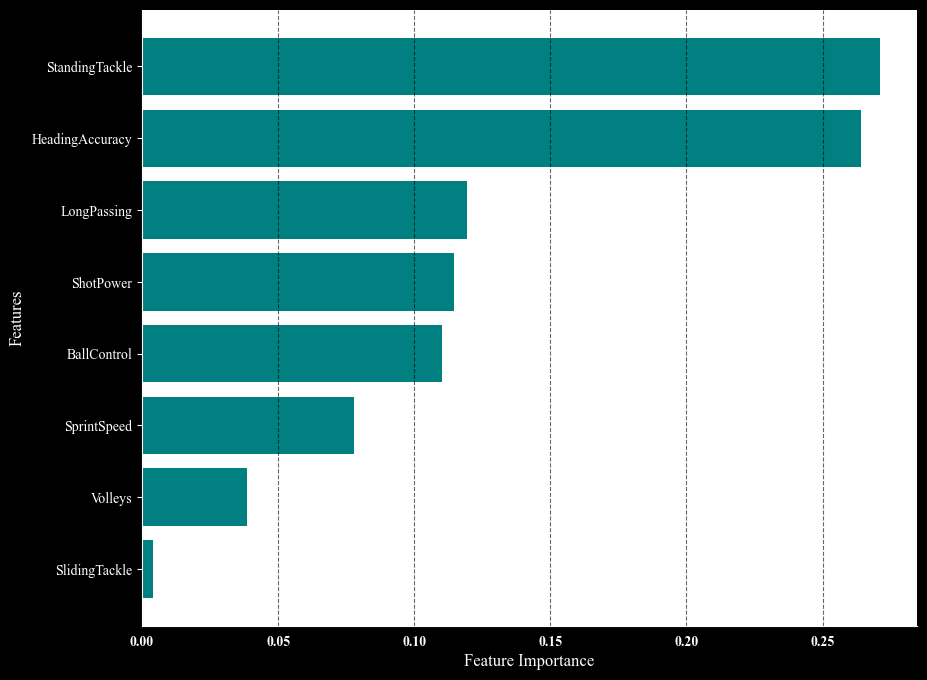

100%|██████████| 30/30 [00:02<00:00, 10.10it/s]


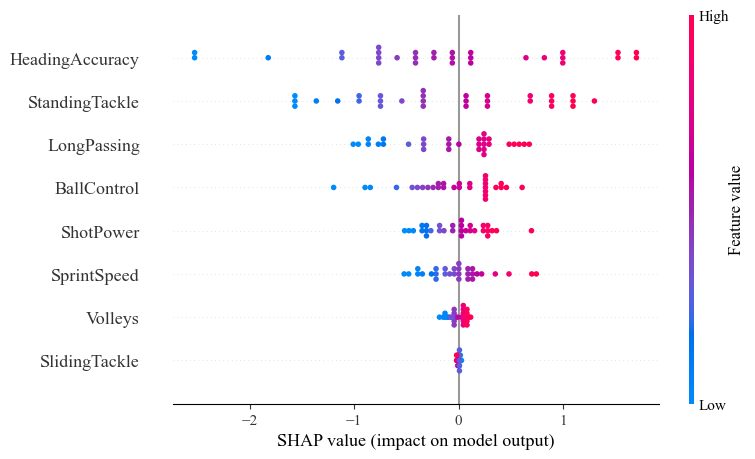

              precision    recall  f1-score   support

       False       0.89      1.00      0.94        49
        True       1.00      0.33      0.50         9

    accuracy                           0.90        58
   macro avg       0.95      0.67      0.72        58
weighted avg       0.91      0.90      0.87        58

Huber Regression training----->


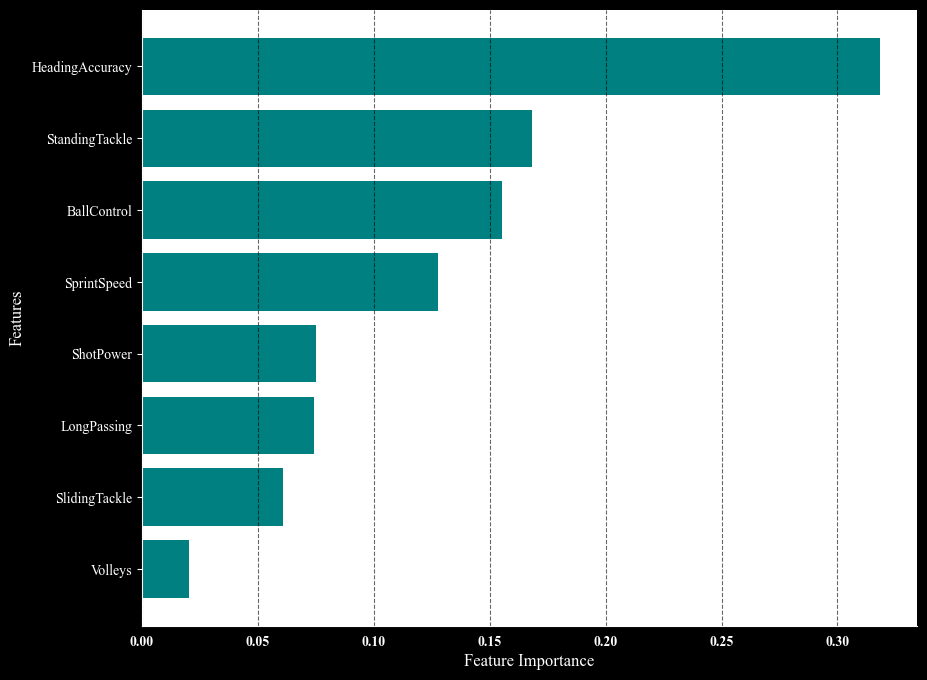

100%|██████████| 30/30 [00:02<00:00, 10.71it/s]


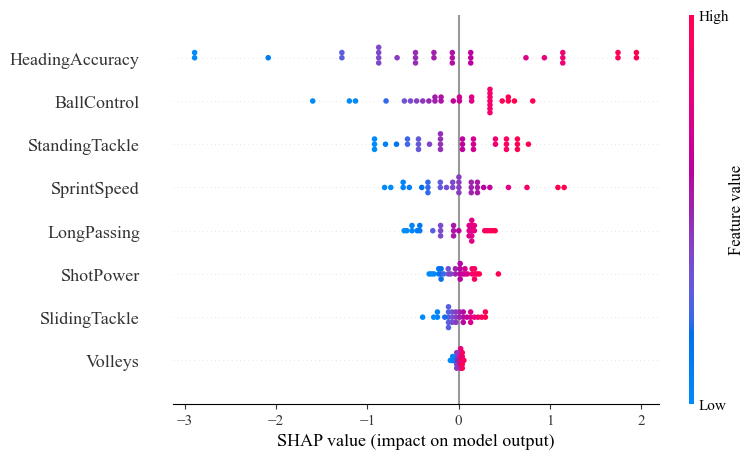

              precision    recall  f1-score   support

       False       0.89      1.00      0.94        49
        True       1.00      0.33      0.50         9

    accuracy                           0.90        58
   macro avg       0.95      0.67      0.72        58
weighted avg       0.91      0.90      0.87        58

Linear Regression training----->


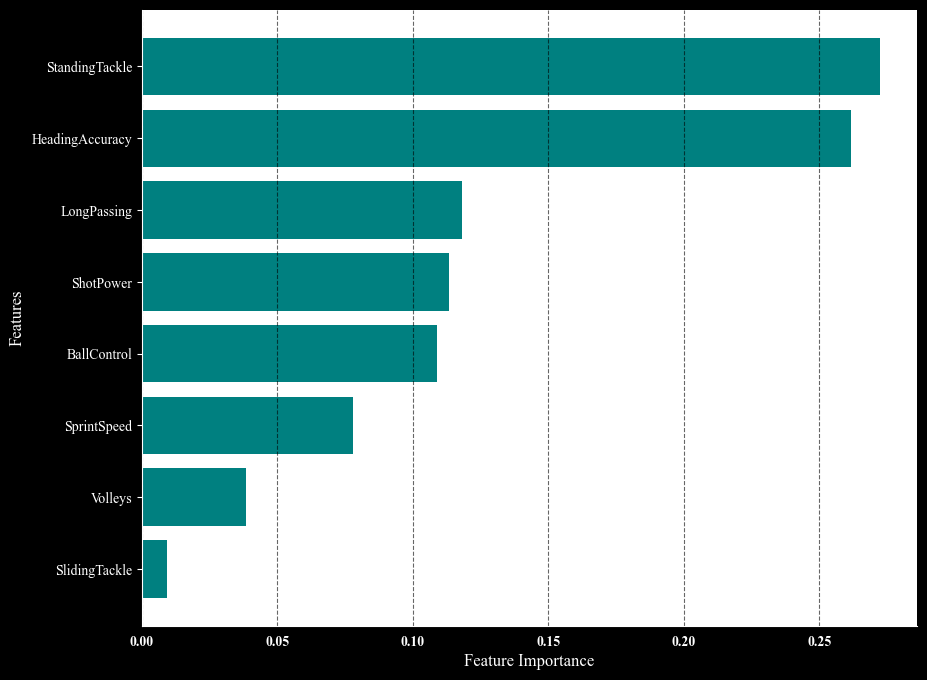

100%|██████████| 30/30 [00:03<00:00,  9.09it/s]


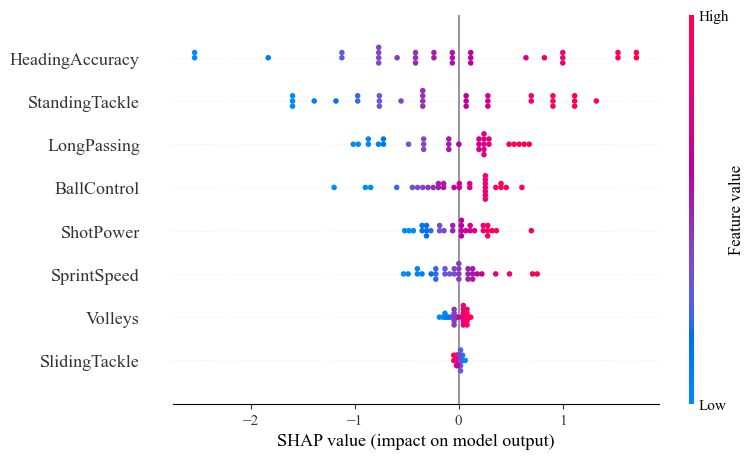

              precision    recall  f1-score   support

       False       0.89      1.00      0.94        49
        True       1.00      0.33      0.50         9

    accuracy                           0.90        58
   macro avg       0.95      0.67      0.72        58
weighted avg       0.91      0.90      0.87        58

Model: Ridge Regression
Mean Squared Error: 21.55
Mean Absolute Error: 3.81
R2 Score: 0.38

Model: Huber Regression
Mean Squared Error: 21.25
Mean Absolute Error: 3.75
R2 Score: 0.39

Model: Linear Regression
Mean Squared Error: 21.53
Mean Absolute Error: 3.81
R2 Score: 0.38



In [547]:
from sklearn.linear_model import LinearRegression,HuberRegressor

from src.sport_analytics.model.eval import plot_feature_importance, log_metrics_in_mlflow_regression,log_metrics_in_mlflow, log_feature_list_as_artifact, plot_shap_summary
from src.sport_analytics.model.prepare import select_features
from src.sport_analytics.utils import *
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge



regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    'Huber Regression':HuberRegressor(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    # 'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    # 'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}
import datetime
# Set the experiment name
mlflow.set_experiment(EXPERIEMENT_NAME)

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():
    from datetime import datetime

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        features = select_features(method=AUTO_FEATURE_SELECT,X=X_train_scaled_df,y=y_train,model=model)
        
        model.fit(X_train_scaled_df[features], y_train)
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        explainer = plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        from sklearn.metrics import  classification_report
        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'explainer':explainer,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [548]:
from src.sport_analytics.model.utils import *
if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.TRAINED_MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [549]:
X_train.describe()

,HeadingAccuracy,ShortPassing,Volleys,FKAccuracy,LongPassing,BallControl,SprintSpeed,Agility,Composure,Defense,ShotPower,Strength,Aggression,Interceptions,StandingTackle,SlidingTackle
count,151.000000,151.00000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,70.225166,62.84106,33.026490,34.450331,57.198675,59.596026,66.993377,56.556291,29.549669,70.655629,52.443709,75.821192,69.052980,69.152318,73.105960,70.099338
std,6.649483,7.91799,9.804725,11.207550,11.005465,9.771509,7.918330,10.321909,30.458866,6.115604,12.124155,7.251746,8.619194,7.641770,5.875545,6.328512
min,54.000000,38.00000,11.000000,18.000000,26.000000,34.000000,34.000000,29.000000,0.000000,54.000000,24.000000,58.000000,42.000000,49.000000,58.000000,54.000000
25%,66.000000,59.00000,27.500000,27.000000,50.000000,52.000000,63.000000,49.000000,0.000000,66.000000,44.000000,71.000000,64.000000,64.500000,69.000000,66.000000
50%,70.000000,64.00000,32.000000,32.000000,58.000000,62.000000,68.000000,57.000000,0.000000,71.000000,51.000000,76.000000,70.000000,70.000000,74.000000,70.000000
75%,75.000000,68.00000,36.500000,37.500000,65.000000,66.500000,72.000000,64.000000,58.500000,75.000000,61.000000,81.000000,74.000000,75.000000,77.000000,74.000000
max,86.000000,78.00000,71.000000,77.000000,79.000000,76.000000,83.000000,79.000000,78.000000,86.000000,82.000000,94.000000,86.000000,86.000000,88.000000,86.000000


In [550]:
y_test.describe()

count    58.000000
mean     74.000000
std       5.953033
min      61.000000
25%      70.250000
50%      74.000000
75%      77.000000
max      89.000000
Name: target, dtype: float64

In [551]:
my_model = regression_results['Huber Regression']['Model']
my_features = regression_results['Huber Regression']['attributes']


In [552]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

58

<Axes: >

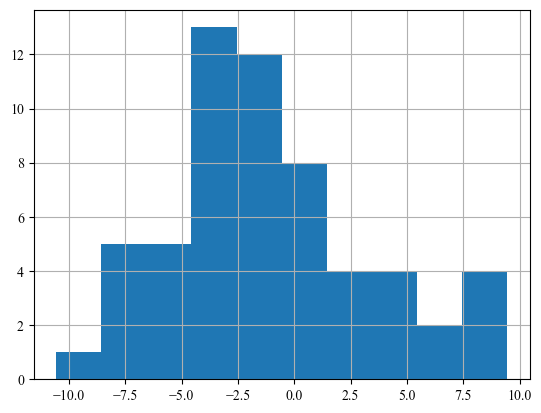

In [553]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

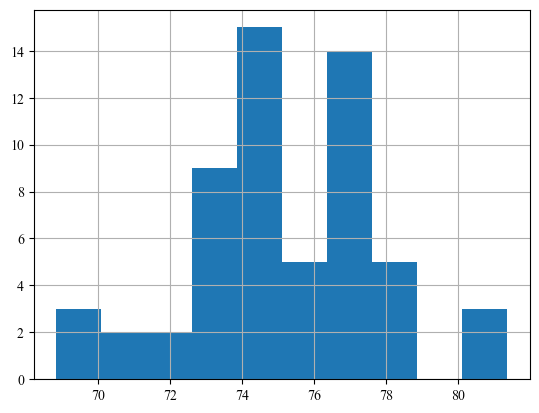

In [554]:
result_df.sort_values(ascending=False).hist()

In [555]:
(y_test-result_df).describe()

count    58.000000
mean     -1.159569
std       4.500326
min     -10.578636
25%      -3.789295
50%      -2.184617
75%       0.775446
max       9.439507
dtype: float64

In [556]:
outlier = (y_test-result_df)>3
X_test[outlier]


,,HeadingAccuracy,ShortPassing,Volleys,FKAccuracy,LongPassing,BallControl,SprintSpeed,Agility,Composure,Defense,ShotPower,Strength,Aggression,Interceptions,StandingTackle,SlidingTackle
Name,FIFA,,,,,,,,,,,,,,,,
W. Saliba,2020,67.0,70.0,32.0,35.0,52.0,58.0,64.0,49.0,65.0,70.0,49.0,76.0,65.0,76.0,72.0,69.0
C. Romero,2020,76.0,55.0,33.0,29.0,46.0,54.0,65.0,64.0,58.0,67.0,51.0,75.0,88.0,76.0,73.0,74.0
Rúben Dias,2020,82.0,71.0,30.0,26.0,58.0,63.0,64.0,48.0,79.0,84.0,74.0,79.0,92.0,76.0,83.0,77.0
L. Martínez,2020,71.0,75.0,49.0,53.0,74.0,75.0,74.0,76.0,75.0,75.0,67.0,72.0,81.0,80.0,78.0,77.0
F. Tomori,2020,63.0,71.0,32.0,40.0,58.0,63.0,83.0,76.0,73.0,69.0,41.0,75.0,67.0,73.0,75.0,70.0
J. Gvardiol,2020,62.0,56.0,23.0,23.0,43.0,54.0,77.0,56.0,54.0,55.0,56.0,80.0,76.0,56.0,62.0,61.0
A. Bella-Kotchap,2020,52.0,42.0,24.0,22.0,38.0,41.0,74.0,43.0,40.0,59.0,38.0,79.0,55.0,61.0,62.0,61.0
R. Araujo,2021,75.0,67.0,32.0,45.0,62.0,58.0,62.0,42.0,47.0,62.0,39.0,73.0,66.0,65.0,70.0,63.0
N. Collins,2021,54.0,57.0,22.0,25.0,51.0,54.0,64.0,41.0,63.0,58.0,36.0,75.0,67.0,64.0,62.0,64.0


In [557]:
y_test[outlier]

Name              FIFA
W. Saliba         2020    84.0
C. Romero         2020    82.0
Rúben Dias        2020    89.0
L. Martínez       2020    84.0
F. Tomori         2020    84.0
J. Gvardiol       2020    82.0
A. Bella-Kotchap  2020    74.0
R. Araujo         2021    86.0
N. Collins        2021    76.0
Gabriel           2020    84.0
Name: target, dtype: float64

In [558]:
result_df[outlier]

Name              FIFA
W. Saliba         2020    75.542371
C. Romero         2020    77.371447
Rúben Dias        2020    81.361630
L. Martínez       2020    80.460316
F. Tomori         2020    76.723413
J. Gvardiol       2020    73.466813
A. Bella-Kotchap  2020    69.769364
R. Araujo         2021    76.560493
N. Collins        2021    70.787321
Gabriel           2020    77.123247
dtype: float64

In [559]:
(y_test/result_df).describe()

count    58.000000
mean      0.983860
std       0.060382
min       0.852210
25%       0.949334
50%       0.970775
75%       1.009939
max       1.123295
dtype: float64

In [560]:
(y_test/result_df).describe()

count    58.000000
mean      0.983860
std       0.060382
min       0.852210
25%       0.949334
50%       0.970775
75%       1.009939
max       1.123295
dtype: float64

In [561]:
np.corrcoef(y_test,result_df)

array([[1.        , 0.70093666],
       [0.70093666, 1.        ]])

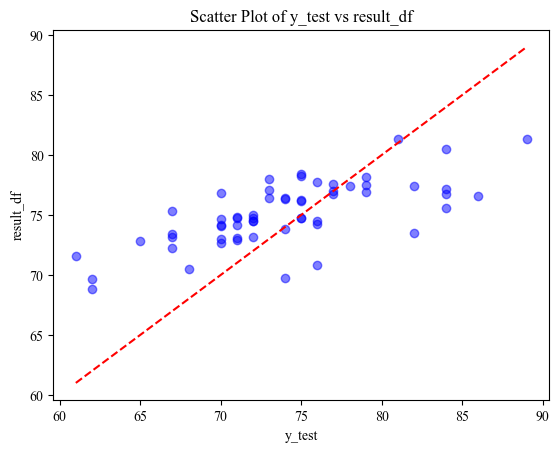

In [562]:
import matplotlib.pyplot as plt
plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [563]:
result_df = result_df.sort_values(ascending=False)

In [564]:
result_df.head(50)

Name             FIFA
Rúben Dias       2020    81.361630
E. Tapsoba       2021    81.300444
L. Martínez      2020    80.460316
A. Caci          2020    78.383783
M. Pongračić     2020    78.232756
M. Simakan       2021    78.159525
T. Kouassi       2021    78.023764
E. Cömert        2021    77.730974
A. Disasi        2021    77.580863
W. Fofana        2021    77.489933
T. Tomiyasu      2020    77.419640
C. Romero        2020    77.371447
Gabriel          2020    77.123247
J. Komar         2020    77.104527
Eric García      2021    77.035165
J. Todibo        2020    76.918677
Javi Hernández   2020    76.829635
F. Tomori        2020    76.723413
V. Nelsson       2020    76.713248
R. Araujo        2021    76.560493
C. Richards      2021    76.444690
D. Fry           2020    76.402479
J. Tanganga      2021    76.321050
Guillamón        2021    76.248225
B. Diakité       2021    76.153920
W. Saliba        2020    75.542371
T. Mengi         2021    75.328600
B. Šutalo        2021    74.96992

In [565]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

3


Name         FIFA
Rúben Dias   2020    81.361630
E. Tapsoba   2021    81.300444
L. Martínez  2020    80.460316
dtype: float64

In [566]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

6


Name         FIFA
C. Romero    2020    77.371447
Gabriel      2020    77.123247
F. Tomori    2020    76.723413
R. Araujo    2021    76.560493
W. Saliba    2020    75.542371
J. Gvardiol  2020    73.466813
dtype: float64

In [567]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

0


Series([], dtype: float64)

In [568]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

49


Name            FIFA
B. Šutalo       2021    74.969922
T. Mengi        2021    75.328600
B. Diakité      2021    76.153920
Guillamón       2021    76.248225
J. Tanganga     2021    76.321050
D. Fry          2020    76.402479
C. Richards     2021    76.444690
V. Nelsson      2020    76.713248
Javi Hernández  2020    76.829635
J. Todibo       2020    76.918677
Eric García     2021    77.035165
J. Komar        2020    77.104527
T. Tomiyasu     2020    77.419640
W. Fofana       2021    77.489933
A. Disasi       2021    77.580863
E. Cömert       2021    77.730974
T. Kouassi      2021    78.023764
M. Simakan      2021    78.159525
M. Pongračić    2020    78.232756
A. Caci         2020    78.383783
dtype: float64

In [569]:
from sklearn.metrics import  classification_report
print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.74      0.61      0.67        38
        True       0.44      0.60      0.51        20

    accuracy                           0.60        58
   macro avg       0.59      0.60      0.59        58
weighted avg       0.64      0.60      0.61        58

